In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import cv2
import glob
from helper import * 
from vehicleDetection import *
from scipy.ndimage.measurements import label

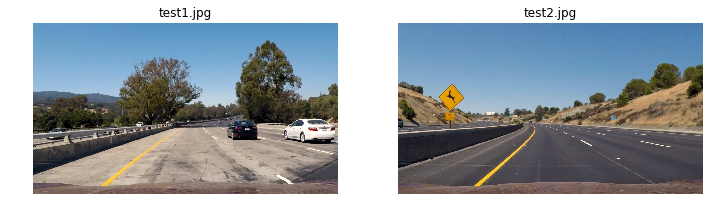

In [2]:
path = "test_images/*.jpg"
test_images = read_images(path)
show_images(test_images[:2])

In [ ]:
hog_images = []
for i in range (len(test_images)):
    img = test_images[i][1]
    img_name = test_images[i][0]
    feature, hog_image = get_hog_feature(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    hog_images.append((img_name, hog_image))
show_images(hog_images[:2], cmap='gray')

# classifier

In [ ]:

car_images = read_images("data/vehicles/*/*.png")
show_images(car_images[:2])

        


In [ ]:
notcar_images = read_images("data/non-vehicles/*/*.png")
show_images(notcar_images[:2])

In [3]:

        
color_space = "YCrCb"
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0,256)

vehicle_detection = VehicleDetection(color_space=color_space, orient=orient,
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_size=spatial_size,
                                    hist_bins=hist_bins, hist_range=hist_range)

In [4]:
cars = glob.glob("data/vehicles/*/*.png")
not_cars = glob.glob("data/non-vehicles/*/*.png")

print(f'numbers of car: {len(cars)}')
print(f'numbers of not car: {len(not_cars)}')

cars_features = []
notcars_features = []
for car in cars:
    image = cv2.cvtColor(cv2.imread(car), cv2.COLOR_BGR2RGB)
    cars_features.append(vehicle_detection.extract_features(image))
    
print("cars finished")

for notcar in not_cars:
    image = cv2.cvtColor(cv2.imread(notcar), cv2.COLOR_BGR2RGB)
    notcars_features.append(vehicle_detection.extract_features(image))
print("not cars finished")

numbers of car: 8792
numbers of not car: 8968


C:\Users\my pc\.conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


cars finished
not cars finished


In [5]:
X_train, y_train, X_test, y_test = vehicle_detection.scale_features(cars_features, notcars_features)
print('Using:',vehicle_detection.orient,'orientations',vehicle_detection.pix_per_cell,
    'pixels per cell and', vehicle_detection.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568


In [6]:
time = vehicle_detection.fit_model(X_train, y_train)
print(time, "Seconds to train SVC...")
print('Test Accuracy of SVC = ', round(vehicle_detection.clf.score(X_test, y_test), 4))

13.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


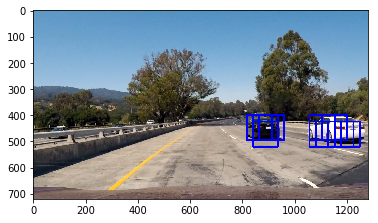

In [7]:


ystart = 400
ystop = 656
scale = 1.5

img = cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
boxes = vehicle_detection.find_cars(img, ystart, ystop, scale)
out_img = vehicle_detection.draw_boxes(img, boxes)

plt.imshow(out_img)

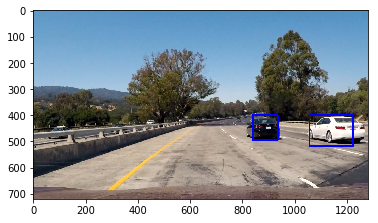

In [8]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = vehicle_detection.add_heat(heat, boxes)
heat = vehicle_detection.apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heat)
fixed_box_img = vehicle_detection.draw_labeled_box(np.copy(img), labels)
plt.imshow(fixed_box_img)

In [23]:
def pipeline(img):
    boxes = vehicle_detection.find_cars(img, ystart, ystop, 1.5)
    boxes += vehicle_detection.find_cars(img, ystart, ystop, 2)
    heat = np.zeros_like(img[:,:,0].astype(np.float))
    heat = vehicle_detection.add_heat(heat, boxes)
    heat = vehicle_detection.apply_threshold(heat, 2)
    labels = label(heat)
    fixed_box_img = vehicle_detection.draw_labeled_box(np.copy(img), labels)
    return fixed_box_img

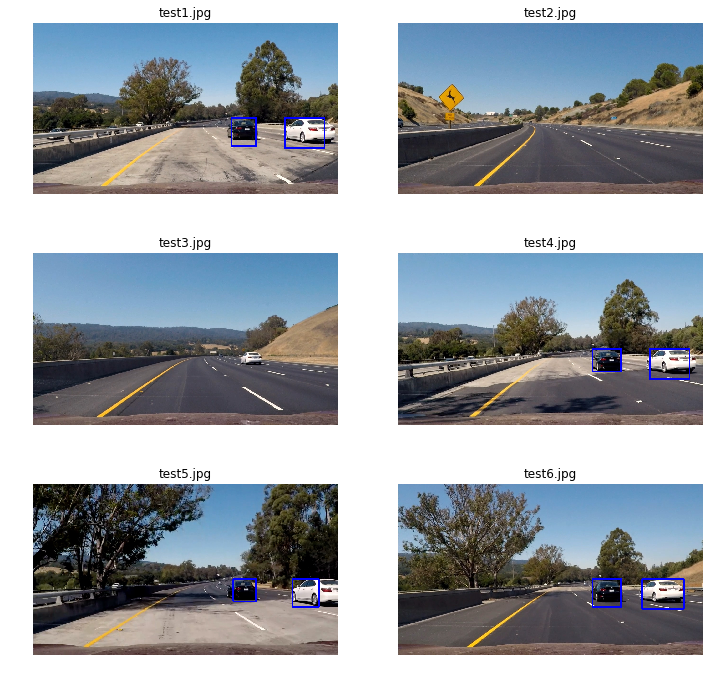

In [24]:
out_imgs = []
for image in test_images:
    img = pipeline(image[1])
    out_imgs.append([image[0], img])


# fast_boxes = list(map(lambda img: vehicle_detection.find_cars(img, ystart, ystop, 1.5), test_images))


show_images(out_imgs)

In [ ]:
from moviepy.editor import VideoFileClip
cars_object = "cars_detection.mp4"

clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(cars_object, audio=False)

Moviepy - Building video cars_detection.mp4.


Moviepy - Writing video cars_detection.mp4



t:   0%|                                                                    | 2/1260 [00:00<08:40,  2.42it/s, now=None]